## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.optimize import fsolve

%matplotlib inline

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares

In [2]:
# Gauss-Hermite quadrature points and weights
gausshermite_xi_deg25, gausshermite_wi_deg25 = np.polynomial.hermite.hermgauss(25)

## Target Mean Flux and P1d

Mean Flux from Turner et al. (2024): https://arxiv.org/html/2405.06743v2

$$ \tau(z) = \tau_0 (1+z)^{\gamma} $$

where, 

$ \tau_0 = (-2.46 \pm 0.14)*10^{-3} $ and $ \gamma = 3.62 \pm 0.04 $.

And mean flux is, $\bar{F}(z) = e^{\tau(z)}$

In [3]:
# Mean flux from Turner et al. (2024)

def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)

DESI EDR parameters, PD13 pivot points (k,z), and fiducial / target P1D are defined at: 
https://github.com/p-slash/qsotools/blob/c58549f41fb2bd56a59c4b4362d8b331334ce13a/py/qsotools/fiducial.py#L42

And PD 13 reffers to: https://arxiv.org/abs/1306.5896

In [4]:
# DESI EDR Parameters (source?)

DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

# set pivot points for k and z using fiducial power estimate
PD13_PIVOT_K = 0.009
PD13_PIVOT_Z = 3.0
    

Baseline power spectrum estimate modifies fitting function from PD13, with best fitting parameters (A, n, $\alpha$, B, $\beta$, $k_1$(km/s)), with a Lorentzian decay: 

$$ \frac{k P(k,z)}{\pi} = A \frac{(k/k_0)^{3 + n + \alpha \ln k/k_0}}{1 + (k / k_1)^2} \left(\frac{1+z}{1+z_0}\right)^{B + \beta \ln k/k_0} $$

where $k_0 = 0.009$ km/s and $z_0 = 3.0$. 

**Table 1.** Top:PD13 BOSS likelihood fitting parameters. Bottom: Karacaylı et al. 2020

| A  | n | $\alpha$ | B | $\beta$ | $k_1$(km/s) |
| ---|---|  ---     |---|---      |---          |
| 0.06 |-2.55|  -.010     |3.55|-0.28      | -  |
| 0.066|-2.685|  -0.22     |3.59|-0.18      |0.53|

In [5]:
# Define target P1D
# note: lmd = k1, PD13_PIVOT_K = k0

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10

    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)

    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)

    return result
    

## Define Lognormal Transformations 

$$D^2(z) =  \left( \frac{1+z}{1+z_0} \right) ^{-\nu} $$

where, $z_0 = 3$, and $\nu = 2.82$

In [6]:
def D2_z(zp, nu=2.82, z0=3.0):
    return np.power((1. + zp) / (1.+z0), -nu)

$$ \tau(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [7]:
def t_of_z(zp, tau0=0.55, tau1=5.1, z0=3.):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)

$$ x(z) = \tau(z) * \exp[-D^2(z) * \sigma^2] $$

$$ x(z) = \tau_0 \left( \frac{1+z}{1+z_0} \right)^{\tau_1} * \exp \left[ \left( \frac{1+z}{1+z_0} \right) ^{-\nu} * \sigma^2 \right] $$

where, $z_0 = 3$, $\tau_0 = 0.55$, and $\tau_1 = 5.1$

In [8]:
def x_of_z(zp, tau0, tau1, nu, sigma2, z0=3):
    return t_of_z(zp, tau0, tau1, z0) * np.exp(-D2_z(zp, nu, z0) * sigma2)

$$ F_d(z) = e^{-\tau(z)} $$

$$ F_d(z) = \exp \left[ -x(z) * \exp [ 2 * D^2_z * \sqrt{1 \sigma^2} * \delta_g ] \right] $$

In [9]:
def Flux_d_z(delta_g, z, tau0, tau1, nu, sigma2, z0=3):
    e1 = np.exp(2 * D2_z(z, nu / 2, z0) * np.sqrt(2 * sigma2) * delta_g)
    e2 = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    return np.exp(-e2 * e1)

$$ \bar{F}_d(z) = \frac{1}{\sqrt{\pi}} \int_{-\infty}^{\infty} F_d(z) d\delta $$

In [10]:
def lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0=3):
    XIXI, ZZ = np.meshgrid(gausshermite_xi_deg25, z)

    Y = Flux_d_z(XIXI, ZZ, tau0, tau1, nu, sigma2, z0)
    result = np.dot(Y, gausshermite_wi_deg25)

    return result / np.sqrt(np.pi)

Input Gaussian Power: 

$$ P(k) = \frac{\exp [ n * q_0 - \alpha q_0^2 ]}{1 + (k/k_1)^{\gamma}} * \exp \left[ -\frac{(k/0.2)^2}{2} \right] $$

where, $q_0 = \ln \left(\frac{k}{0.001}+10^{-15}\right)$

In [11]:
def lognGeneratingPower(k, n=0.5, alpha=0.26, gamma=1.8, k1=0.04):
    q0 = np.log(k / 0.001 + 1e-15)
    return np.exp(n * q0 - alpha * q0**2) / (1. + (k / k1)**gamma) * np.exp(-(k / 0.2)**2 / 2)

# Fitting for Mean Flux

Fit for mean flux example: 

In [12]:
# create redshift array
z_array = np.linspace(1.8, 5.0, 500)

# choose precision
precision = 1e-5

In [13]:
# def model and error / precision
F_turner = turner24_mf(z_array)
Err_turner = F_turner * precision + 1e-8

Define a cost funciton: 

$$ d = \frac{\bar{Flux}_{model}-\bar{Flux}_{measured}}{Error_{model}} $$

and, $cost = d \cdot d$ 

In [14]:
# def cost function 
def cost(tau0, tau1, nu, sigma2):
    d = (F_turner - lognMeanFluxGH(z_array, tau0, tau1, nu, sigma2, z0=3)) / Err_turner
    return d.dot(d)

# Set initial guesses for fitting parameters
tau0, tau1, nu, sigma2 = 0.55, 5.1, 2.82, 1.0

# minimizer: minimizes cost and determines best fit values for parameters
mini = Minuit(cost, tau0, tau1, nu, sigma2)
mini.errordef = Minuit.LEAST_SQUARES
mini.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9.659e+05                  │              Nfcn = 376              │
│ EDM = 2.08e-08 (Goal: 0.0002)    │            time = 0.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau0   │ 673.77e-3 │  0.06e-3  │            │            │         │         │       │
│ 1 │ tau1   │  5.31008  │  0.00016  │            │            │         │         │       │
│ 2 │ nu     │  2.16175  │  0.00017  │            │            │         │         │       │
│ 3 │ sigma2 │  1.50381  │  0.00014  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │      tau0      tau1        nu    sigma2 │
├────────┼─────────────────────────────────────────┤
│   tau0 │  3.64e-09     -6e-9      8e-9      9e-9 │
│   tau1 │     -6e-9  2.61e-08 -0.027e-6 -0.015e-6 │
│     nu │      8e-9 -0.027e-6  2.91e-08  0.019e-6 │
│ sigma2 │      9e-9 -0.015e-6  0.019e-6  2.01e-08 │
└────────┴─────────────────────────────────────────┘

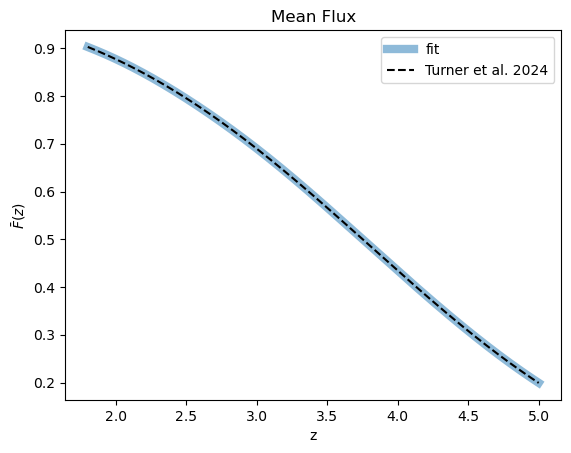

In [15]:
plt.plot(z_array, lognMeanFluxGH(z_array, *mini.values), color='tab:blue', ls='-', label='fit', lw='6', alpha = 0.5)
plt.plot(z_array, F_turner, color='black', ls='--', label='Turner et al. 2024')
plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()

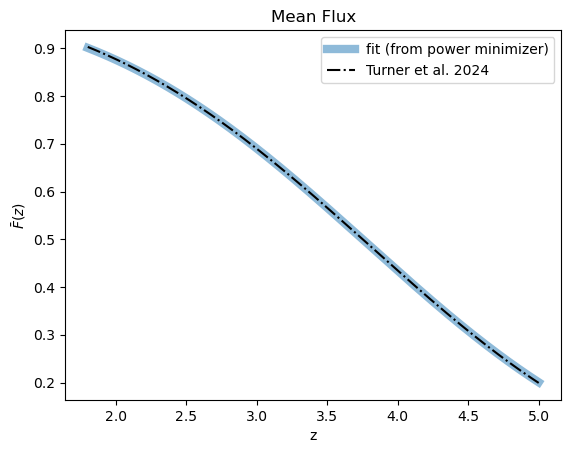

In [16]:
# Best Fit Tau0: 0.38361017450395224
# Best Fit Tau1: 4.599362884319737
# Best Fit Nu: 1.7012552066724722
# bsetfit sigma (from pgauss): 0.3908

plt.plot(z_array, lognMeanFluxGH(z_array, 0.3836, 4.599, 1.7016, 0.3908), color='tab:blue', ls='-', label='fit (from power minimizer)', lw='6', alpha=0.5)
plt.plot(z_array, F_turner, color='black', ls='-.', label='Turner et al. 2024')
plt.title('Mean Flux')
plt.xlabel('z')
plt.ylabel(r'$\bar F(z) $')
plt.legend()

In [17]:
# # Sanity Check

# tau_0_test = 673.77e-3
# tau_1_test = 5.31008
# nu_test = 2.16175	
# sigma2_test = 1.50381

# plt.plot(z_array, lognMeanFluxGH(z_array, tau_0_test, tau_1_test, nu_test, sigma2_test))

# Fit for Correlation Function

### get correlation function ($\xi_G$) from P1D estimates


In [18]:
# Calculate meshgrid for Gauss-Hermite once
YY1, YY2 = np.meshgrid(gausshermite_xi_deg25, gausshermite_xi_deg25, indexing='ij')
WW1, WW2 = np.meshgrid(gausshermite_wi_deg25, gausshermite_wi_deg25, indexing='ij')

# create velocity array 
# numvpoints = 2**16
numvpoints = 2**12
dv = 1.0 # (km/s)
v_array = np.arange(numvpoints) * dv
print('Number of v-points: '+ str(numvpoints))

# k-mode array
k_arr  = 2. * np.pi * np.fft.rfftfreq(2 * numvpoints, d=dv)

# redshift array (2.0, 2.2 ... 4.4)
z_p1d_arr = np.arange(13) * 0.2 + 2.0
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])

# fit P1D of DESI EDR
# Start with an empty array the size / shape of k and z arrays
p1d_edr_fit = np.empty((zlist.size, k_arr.size))

# Evaluate P1D for each (k,z), using DESI EDR Param. def. above
for i, z in enumerate(zlist):
    p1d_edr_fit[i] = evaluatePD13Lorentz((k_arr, z), *DESI_EDR_PARAMETERS)

Number of v-points: 4096


In [19]:
xif_edr_fit = np.empty((zlist.size, numvpoints))

for i, z in enumerate(zlist):
    # xif_edr_fit[i] = np.fft.irfft(p1d_edr_fit[i])[:numvpoints] / dv
    xif_edr_fit[i] = np.fft.irfft(p1d_edr_fit[i])[:numvpoints] / dv

In [20]:
# for z, xi in zip(zlist, xif_edr_fit):
#     plt.semilogx(1 + v_array, xi, label=z)
# # plt.yscale("symlog")
#     plt.legend()

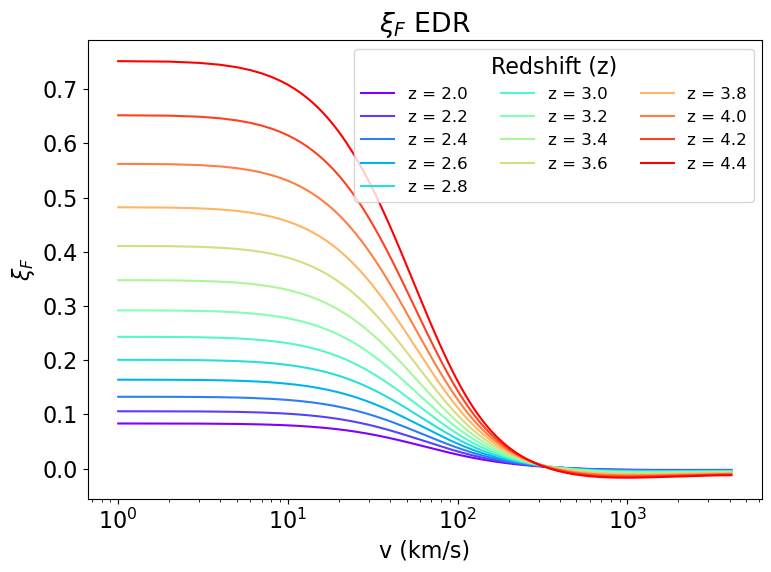

In [21]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

# Plot the correlation function for each z value
for z, xi in zip(zlist, xif_edr_fit):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plt.semilogx(1 + v_array, xi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='upper right', ncol=3, title="Redshift (z)", fontsize=12)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.title(r'$\xi_F$ EDR')
plt.tight_layout()
plt.show()


### get correlation function ($\xi_G$) from P1D estimates


In [22]:
xif_edr_fit = np.empty((zlist.size, numvpoints))

for i, z in enumerate(zlist):
    xif_edr_fit[i] = (np.fft.irfft(p1d_edr_fit[i]))[:numvpoints] / dv

In [23]:
# for z, xi in zip(zlist, xif_edr_fit):
#     plt.semilogx(1 + v_array, xi, label=z)
# # plt.yscale("symlog")
#     plt.legend()

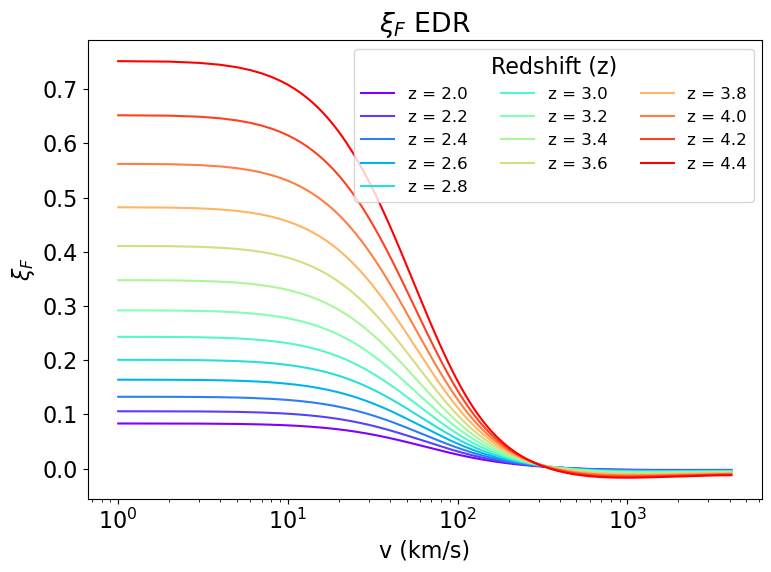

In [24]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

# Choose a colormap (e.g., 'viridis', 'plasma', etc.)
cmap = plt.cm.rainbow  # You can use 'viridis', 'plasma', or other color schemes
zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])
norm = plt.Normalize(vmin=min(zlist), vmax=max(zlist))  # Normalize to the range of z_list

# Plot the correlation function for each z value
for z, xi in zip(zlist, xif_edr_fit):
    color = cmap(norm(z))  # Get the corresponding color from the colormap
    plt.semilogx(1 + v_array, xi, label=f"z = {z:.1f}", color=color)  # Format z to one decimal place

# Set up the legend and plot adjustments
plt.legend(loc='upper right', ncol=3, title="Redshift (z)", fontsize=12)
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.title(r'$\xi_F$ EDR')
plt.tight_layout()
plt.show()


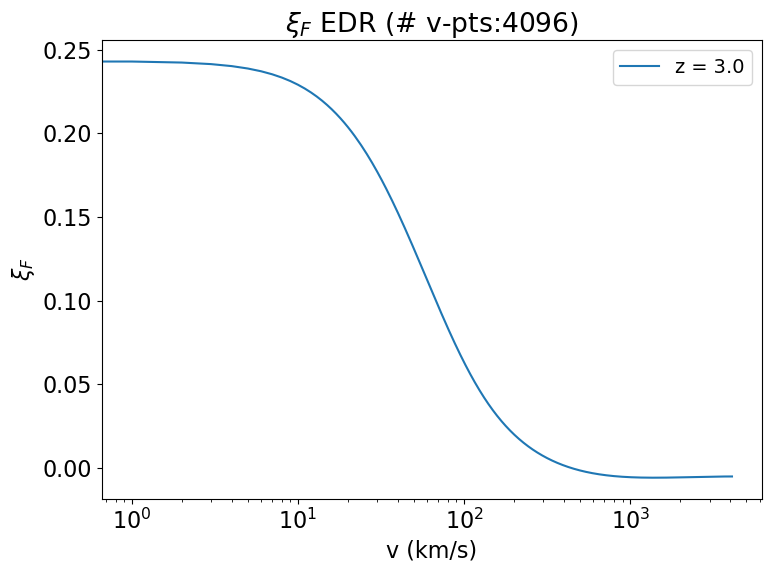

In [25]:
# locate z=3
zlist[5]

# plot only z=3 for xi_F EDR data:

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(v_array, xif_edr_fit[5], label='z = '+str(zlist[5]))
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi_F$')
plt.title(r'$\xi_F$ EDR (# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=14)
plt.tight_layout()

now, we want to find the $\xi_G$ that gives us the correct / desired EDR $\xi_F$

In [34]:

#####################################################

# lognormal xi_f from xi_g
# goes point by point, not dealing with arrays

def lognXiFfromXiG_old(z, xi_gauss, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: float
        Single xi_g value from Gaussian random field
    """
    # sigma2 = xi_gauss[0]
    sigma2 = 1.50381
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine])

    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return a single xi_f scalar
    xi_f = np.sum(tempfunc) / np.pi

    return xi_f

########################################################################

zlist = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4])

# xi_f from data (EDR = early data release)
xif_edr_fit = np.empty((zlist.size, numvpoints))

for i, z in enumerate(zlist):
    xif_edr_fit[i] = np.fft.irfft(p1d_edr_fit[i])[:numvpoints] / dv
    
########################################################################


In [35]:
# check that lognXiFfromXiG returns a single xi_f value for a single xi_g value
lognXiFfromXiG_old(z=3, xi_gauss=0.2) # CHECK

0.027249137574903593

In [36]:
# Objective function for fsolve
def objective(xi_g, z, xi_f_target):
    """
    Compute the difference between the target xi_f values and the xi_f values
    calculated from xi_g using lognXiFfromXiG_old.

    Parameters
    ----------
    xi_g : array-like
        Current guess for xi_g values.
    z : float
        Redshift at which xi_f is calculated.
    xi_f_target : array-like
        Target xi_f values.

    Returns
    -------
    array-like
        Residuals between calculated and target xi_f.
    """
    xi_f_calculated = np.array([lognXiFfromXiG_old(z, xi_g_i) for xi_g_i in xi_g])
    return xi_f_calculated - xi_f_target

# Set parameters for optimization
redshift_index = 5          # Index corresponding to z = 3.0
z = zlist[redshift_index]   # Redshift value
xi_f_target = xif_edr_fit[redshift_index]  # Target xi_f array for z = 3.0

# Initial guess for xi_g as a 1D array matching the length of xi_f_target
xi_g_initial_guess = np.full_like(xi_f_target, fill_value=0.1)

# Optimize xi_g to match xi_f_target
xi_g_optimized = fsolve(objective, xi_g_initial_guess, args=(z, xi_f_target))

# Print results
# print(f"Optimized xi_g array for z={z}:\n{xi_g_optimized}")


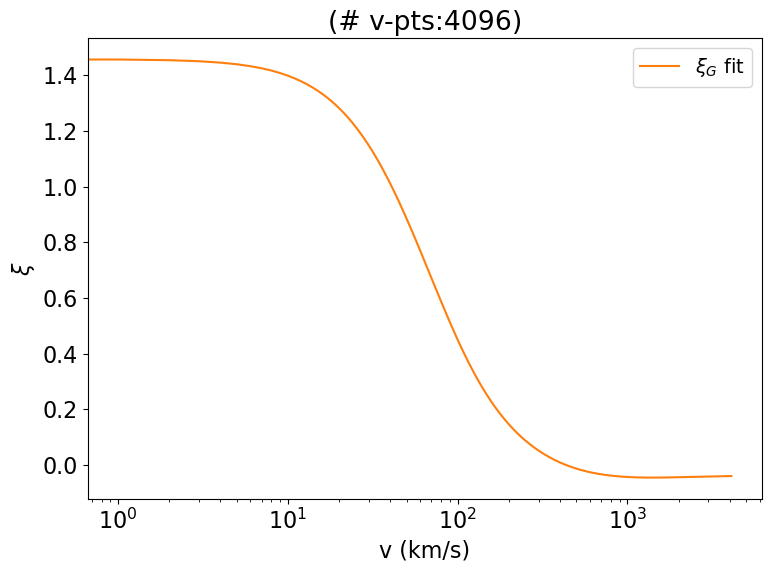

In [37]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
plt.semilogx(xi_g_optimized, color='tab:orange', label= r'$\xi_G$ fit')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title('(# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=14)
plt.tight_layout()

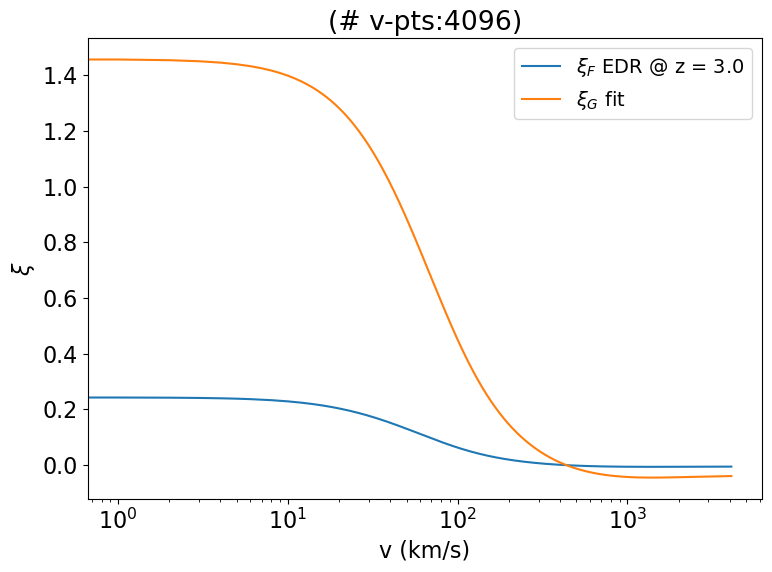

In [38]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(xif_edr_fit[5], label=r'$\xi_F$ EDR @ z = '+str(zlist[5]), color='tab:blue')
plt.semilogx(xi_g_optimized, label= r'$\xi_G$ fit', color='tab:orange')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title('(# v-pts:'+str(numvpoints)+')')
plt.legend(fontsize=14)
plt.tight_layout()

Now we need to get $\xi_F$ from $\xi_G$ optimized

In [39]:
# get xi_F from xi_G optimized
# go back to working with arrays of xi_g and xi_f
def lognXiFfromXiG(xi_gauss, z, tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3):
    """
    Arguments
    ---------
    z: float
        Single redshift
    tau0, tau1: float
        Amplitude (tau0) and power (tau1) of optical depth
    nu: float
        Slope of growth (a(z) -> D(z))
    xi_gauss: np.array(float)
        Array of xi_g values from Gaussian random field
    """
    sigma2 = xi_gauss[0]
    xi_sine = np.clip(xi_gauss / sigma2, -1, 1)
    xi_cosine = np.sqrt(1 - xi_sine**2)
    XI_VEC = np.array([xi_sine, xi_cosine]).T

    # Weighted vector computation
    YY2_XI_VEC_WEIGHTED = np.dot(XI_VEC, np.array([YY1, YY2]).transpose(1, 0, 2))

    # Redshift-dependent computations
    mean_flux_z = lognMeanFluxGH(z, tau0, tau1, nu, sigma2, z0)
    sigmaz = D2_z(z, nu / 2, z0) * np.sqrt(sigma2)
    tempxz = x_of_z(z, tau0, tau1, nu, sigma2, z0)
    delta1 = YY1 * sigmaz * 2 * np.sqrt(2)
    delta2 = YY2_XI_VEC_WEIGHTED * sigmaz * 2 * np.sqrt(2)

    F1 = np.exp(-tempxz * np.exp(delta1))
    F2 = np.exp(-tempxz * np.exp(delta2))
    D1 = F1 / mean_flux_z - 1
    D2 = F2 / mean_flux_z - 1
    tempfunc = WW1 * WW2 * D1 * D2

    # Return xi_f array
    xi_f = np.sum(tempfunc, axis=(1, 2)) / np.pi
    return xi_f

######################################################

xi_f_optimized = lognXiFfromXiG(xi_gauss = xi_g_optimized, z = 3,
                                tau0=673.77e-3, tau1=5.31008, nu=2.16175, z0=3)

######################################################


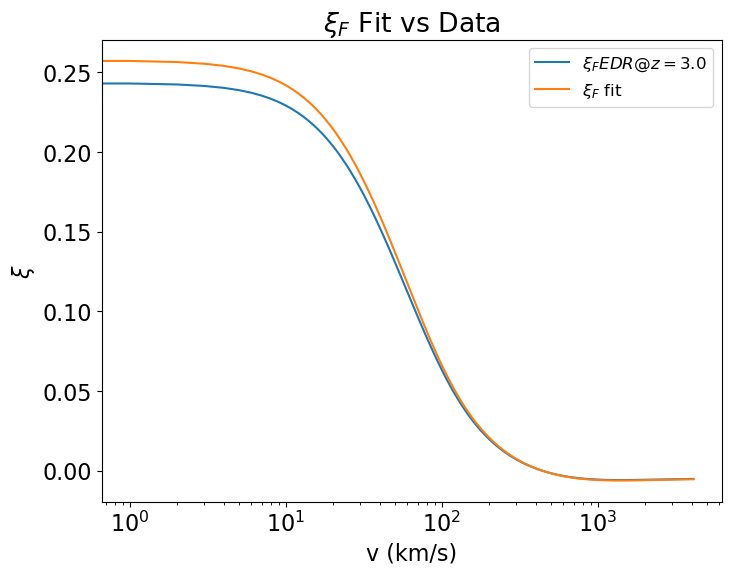

In [40]:
# plot xi F
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

plt.semilogx(xif_edr_fit[5], label = r'$\xi_F EDR @ z = $'+str(zlist[5]), color = 'tab:blue')
plt.semilogx(xi_f_optimized, label=r"$\xi_F$ fit", color="tab:orange")

plt.legend(fontsize=12, loc='upper right')
plt.xlabel('v (km/s)')
plt.ylabel(r'$\xi$')
plt.title(r"$\xi_F$ Fit vs Data")
plt.show()

Try to get power from $\xi_F$

In [41]:
P_k.size

NameError: name 'P_k' is not defined

In [42]:
k_arr.size

4097

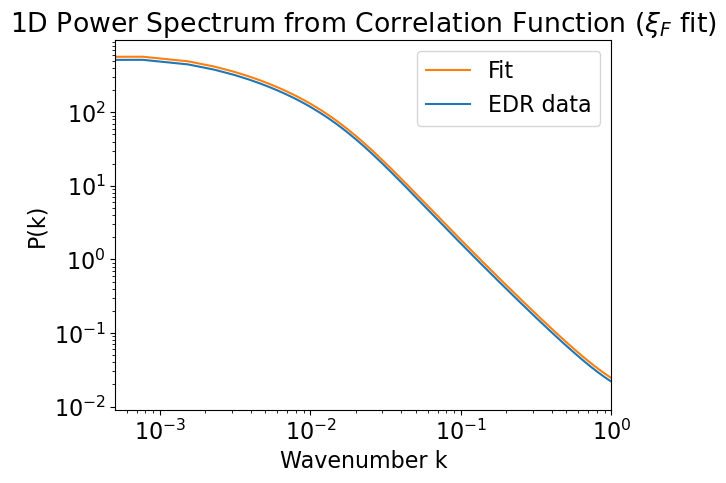

In [43]:
# get power from xi_f

xi_F_values = xi_f_optimized
xi_F_values_data = xif_edr_fit[5]

# assuming xi_F(v) is the correlation function in velocity space
# and v is the velocity array (note: dv = 1 km/s)
v = v_array[:len(xi_F_values)]  # Velocity grid (matching the length of xi_F)

# perform FFT of the correlation function
fft_xi_F = np.fft.fft(xi_F_values)
fft_xi_F_data = np.fft.fft(xi_F_values_data)

# Power spectrum proportional to magnitude quared of FFT
P_k = np.abs(fft_xi_F)**2
P_k_data = np.abs(fft_xi_F_data)**2

# compute the corresponding wavenumbers k (1d space, k conjugate to v)
k = np.fft.fftfreq(len(P_k), d = dv) * 2 * np.pi # convert to physical wavenumbers

# Normalize power spectrum by number of points (N) ?
# P_k = P_k / len(v)
# P_k_data = P_k_data / len(v)

# Plot the 1D power spectrum
plt.loglog(k_arr[:len(P_k)], P_k, label='Fit', color='tab:orange')
plt.loglog(k_arr[:len(P_k)], P_k_data, label = 'EDR data', color='tab:blue')
plt.xlabel('Wavenumber k')
plt.ylabel('P(k)')
plt.legend()
plt.xlim(right=10e-1)
plt.title(r'1D Power Spectrum from Correlation Function ($\xi_F$ fit)')
plt.show()

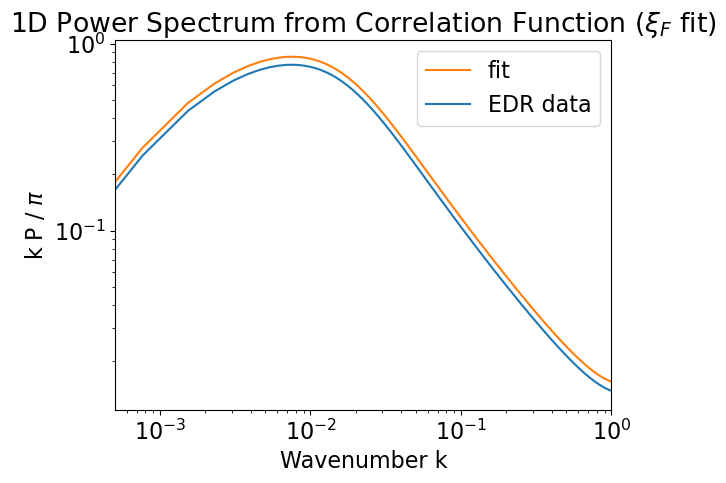

In [44]:
# normalize  1D power spectrum
plt.loglog(k_arr[:len(P_k)], P_k * k / np.pi, label='fit', color = 'tab:orange')
plt.plot(k_arr[:len(P_k)], P_k_data * k / np.pi, label='EDR data', color = 'tab:blue')
plt.xlabel('Wavenumber k')
plt.ylabel(r'k P / $\pi$')
plt.xlim(right=10e-1)
plt.legend()
plt.title(r'1D Power Spectrum from Correlation Function ($\xi_F$ fit)')
plt.show()

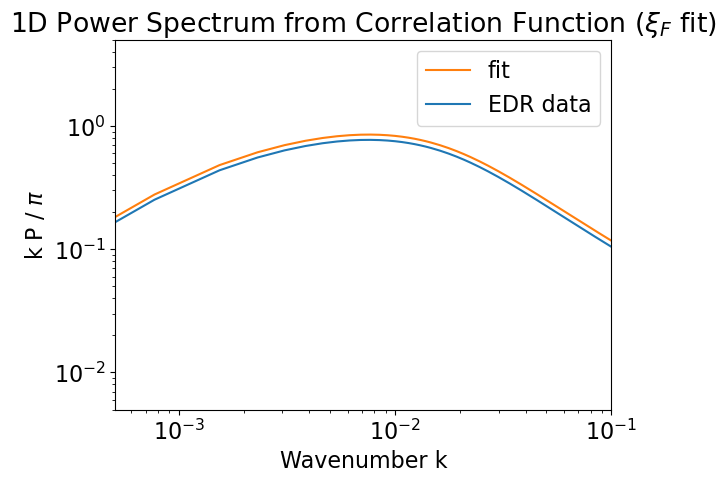

In [55]:
# normalize  1D power spectrum
plt.loglog(k_arr[:len(P_k)], P_k * k / np.pi, label='fit', color = 'tab:orange')
plt.plot(k_arr[:len(P_k)], P_k_data * k / np.pi, label='EDR data', color = 'tab:blue')
plt.xlabel('Wavenumber k')
plt.ylabel(r'k P / $\pi$')
plt.xlim(right=10e-2)
plt.ylim([5e-3, 5e-0])
plt.legend()
plt.title(r'1D Power Spectrum from Correlation Function ($\xi_F$ fit)')
plt.show()

In [ ]:
# try with error bars for EDR data?